In [1]:
import json

import numpy as np
import cv2

from PIL import Image

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
from sklearn.model_selection import train_test_split
import copy

In [2]:
!pip install timm mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.9 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import timm

In [4]:
batch_size = 32

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'cpu'

In [6]:
!wget http://domedb.perception.cs.cmu.edu/panopticDB/hands/hand_labels.zip

--2023-06-13 21:12:53--  http://domedb.perception.cs.cmu.edu/panopticDB/hands/hand_labels.zip
Resolving domedb.perception.cs.cmu.edu (domedb.perception.cs.cmu.edu)... 128.2.220.8
Connecting to domedb.perception.cs.cmu.edu (domedb.perception.cs.cmu.edu)|128.2.220.8|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 589711996 (562M) [application/zip]
Saving to: ‘hand_labels.zip’

hand_labels.zip     100%[===================>] 562.39M  58.8MB/s    in 7.8s    

2023-06-13 21:13:01 (71.9 MB/s) - ‘hand_labels.zip’ saved [589711996/589711996]



In [7]:
!unzip hand_labels.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: hand_labels/manual_test/ex2_2.flv_000007_l.json  
  inflating: hand_labels/manual_test/Berry_roof_story.flv_000047_r.jpg  
  inflating: hand_labels/manual_test/003757109_01_l.json  
  inflating: hand_labels/manual_test/Berry_sermon_story.flv_000019_l.jpg  
  inflating: hand_labels/manual_test/075338811_01_r.jpg  
  inflating: hand_labels/manual_test/Berry_sermon_story.flv_000069_l.json  
  inflating: hand_labels/manual_test/092033356_04_l.jpg  
  inflating: hand_labels/manual_test/070301896_02_r.jpg  
  inflating: hand_labels/manual_test/ex2_2.flv_000080_r.json  
  inflating: hand_labels/manual_test/ex2_2.flv_000002_r.jpg  
  inflating: hand_labels/manual_test/069318700_02_r.json  
  inflating: hand_labels/manual_test/043285111_01_r.jpg  
  inflating: hand_labels/manual_test/098925624_03_r.jpg  
  inflating: hand_labels/manual_test/041354052_01_l.jpg  
  inflating: hand_labels/manual_test/Berry_sermon_stor

# Prepare data

Dataset: [Hand Keypoint Detection in Single Images
using Multiview Bootstrapping](http://domedb.perception.cs.cmu.edu/handdb.html)

In [8]:
files = [os.path.join('hand_labels/manual_train', file) for file in os.listdir('hand_labels/manual_train')]

In [ ]:
files[1]

'Alexander_a_visit_to_the_cafe.flv_000074_r.json'

In [ ]:
split1 = json.load(open(os.path.join('hand_labels/manual_train', files[1])))

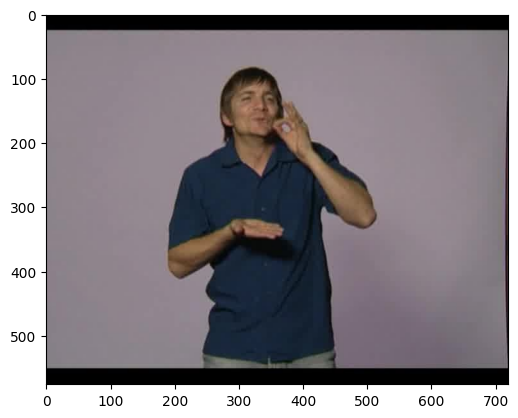

In [ ]:
img_path = os.path.join('hand_labels/manual_train', files[1].replace('.json', '.jpg'))
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

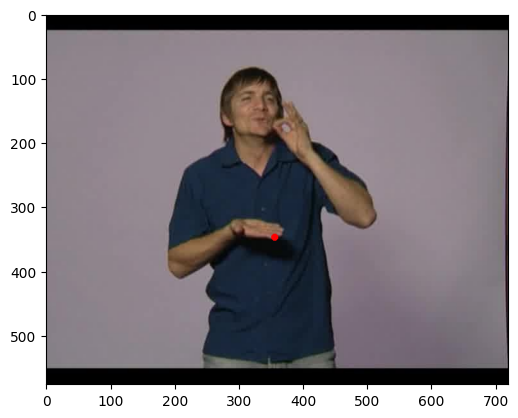

In [ ]:
img_new = img.copy()
x_pos, y_pos = int(split1['hand_pts'][8][0]), int(split1['hand_pts'][8][1])
img_new = cv2.circle(img_new, (x_pos, y_pos), 3, (255, 0, 0), 4)

plt.imshow(img_new)

In [ ]:
split1['hand_pts']

[[303.7593078613281, 328.51190185546875, 1.0],
 [298.14999389648443, 327.3944702148438, 1.0],
 [295.3453369140625, 331.02618408203125, 1.0],
 [298.43048095703125, 335.21658325195307, 1.0],
 [301.23513793945307, 339.12765502929693, 1.0],
 [318.90447998046875, 340.8038330078125, 1.0],
 [336.01290893554693, 344.43554687499994, 1.0],
 [344.42687988281244, 345.83233642578125, 1.0],
 [356.4869079589842, 347.22915649414057, 1.0],
 [325.91613769531244, 336.3340454101563, 1.0],
 [343.3050231933595, 339.4070129394531, 1.0],
 [357.6087951660156, 342.2006530761719, 1.0],
 [367.70556640624994, 343.5974426269532, 1.0],
 [331.5254516601563, 331.8642578125, 1.0],
 [348.07293701171875, 335.49597167968744, 1.0],
 [359.5720520019531, 336.3340454101563, 1.0],
 [369.10787963867193, 336.05468750000006, 1.0],
 [335.1715087890625, 326.8357543945313, 1.0],
 [348.63388061523443, 329.9087219238281, 1.0],
 [356.20645141601557, 330.46743774414057, 1.0],
 [363.05459594726557, 329.5556640625, 1.0]]

In [9]:
files_paths = []
files = sorted(files)
len_dataset = 350
i = 0
for file_path in files:
    if i >= len_dataset:
        break
    is_jpg = file_path.split('.')[-1] == 'jpg'
    side = file_path.split('.')[-2].split('_')[-1]
    if side == 'r' and is_jpg:
        files_paths.append(file_path)
        i += 1

In [10]:
len(files_paths)

350

In [11]:
train_paths = files_paths[:250]
val_paths = files_paths[250:]

# ANNOTATIONS

In [12]:
def get_annotations(paths):
    annotations = []
    for curr_path in paths:
        json_path = curr_path.replace('.jpg', '.json')
        split = json.load(open(json_path))

        annotations.append(split)
    return annotations

In [13]:
train_meta = get_annotations(train_paths)
val_meta = get_annotations(val_paths)

In [ ]:
np.array(train_meta[0]['hand_pts'])[:, :2].ravel()

array([461.87872314, 497.2376709 , 477.00186157, 504.04269409,
       492.125     , 518.01092529, 493.20523071, 535.56066895,
       484.92349243, 545.94732666, 472.32089233, 516.22009277,
       470.52050781, 533.41174316, 473.76119995, 539.50042725,
       475.20147705, 532.33728027, 458.99813843, 509.41506958,
       456.47763062, 534.12805176, 461.87872314, 536.99334717,
       461.87872314, 526.96490479, 445.67538452, 510.84771729,
       444.95523071, 533.41174316, 446.39553833, 531.26281738,
       447.47573853, 525.17407227, 436.67352295, 509.41506958,
       435.95336914, 530.54644775, 441.71456909, 534.48620605,
       443.15484619, 527.68121338])

In [77]:
class KeypointsDataset(Dataset):

    def __init__(self, meta, paths):
        self.meta = meta
        self.paths = paths
        # self.preprocessing = A.Compose([
        #     A.Resize(height=224, width=224),
            # A.Normalize(),
            # ToTensorV2()
        # ])

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = self.paths[idx]
        image = Image.open(image_name).convert('RGB')
        image = np.asarray(image)

        x_min = int(np.array(self.meta[idx]['hand_pts'])[:, 0].min())
        x_max = int(np.array(self.meta[idx]['hand_pts'])[:, 0].max())
        y_min = int(np.array(self.meta[idx]['hand_pts'])[:, 1].min())
        y_max = int(np.array(self.meta[idx]['hand_pts'])[:, 1].max())
        image = image[y_min:y_max,x_min:x_max]

        # image = self.preprocessing(image=image)['image']

        keypoints = np.array(self.meta[idx]['hand_pts'])
        keypoints[:, 0] -= x_min
        keypoints[:, 0] /= (x_max - x_min)
        keypoints[:, 1] -= y_min
        keypoints[:, 1] /= (y_max - y_min)

        keypoints = keypoints[:, :2].ravel()
        # for i in range(0, len(self.meta[idx]['keypoints']), 3):
        #     keypoints.append((self.meta[idx]['keypoints'][i] - x_min) / (x_max - x_min))
        #     keypoints.append((self.meta[idx]['keypoints'][i+1] - y_min) / (y_max - y_min))
        #     keypoints.append(float(self.meta[idx]['keypoints'][i+2] > 0))

        return image, torch.Tensor(keypoints)

In [79]:
train_dataset = KeypointsDataset(meta=train_meta, paths=train_paths)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

val_dataset = KeypointsDataset(meta=val_meta, paths=val_paths)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

183
86


151
77


90
22


246


46


142


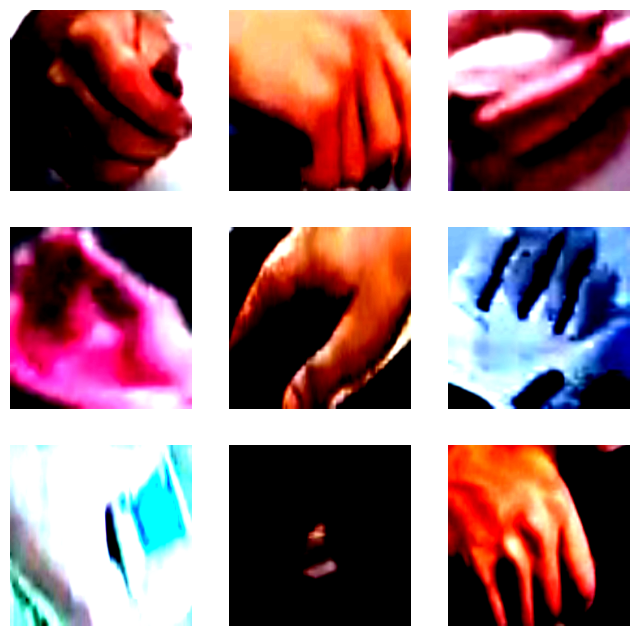

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    print(sample_idx)
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    # plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img)
plt.show()

# Metrics

In [105]:
def get_metric(y_true, y_pred):
    # Евклидово расстояние

    # Compute the L2/Euclidean Distance
    distances = np.linalg.norm(y_pred - y_true, axis=-1)
    return distances.mean()

# Create model
Модель mediapipe, которую используем в инференсе

In [17]:
import mediapipe as mp

In [70]:
mp_hands = mp.solutions.hands
mp_model = mp_hands.Hands(
    static_image_mode=False, # only static images
    max_num_hands=1, # max 2 hands detection
    min_detection_confidence=0.1) # detection confidence

# Test

In [114]:
sum_metric = 0
len_metric = 0
for image, targets in tqdm(val_dataset):
    image_height, image_width, c = image.shape # get image shape
    # iterate on all detected hand landmarks
    results = mp_model.process(image)
    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]
        keypoints = []
        for landmark in hand_landmarks.landmark:
            keypoints.append(landmark.x)
            keypoints.append(landmark.y)
        keypoints = np.array(keypoints)
        sum_metric += get_metric(targets.numpy(), keypoints)
        len_metric += 1

print('Метрика на mediapipe:', sum_metric / len_metric)

  0%|          | 0/100 [00:00<?, ?it/s]

Метрика на mediapipe: 1.2572068172344837


# Inference

In [115]:
val_id = 4
image_path = val_paths[val_id]
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)

x_min = int(np.array(val_meta[val_id]['hand_pts'])[:, 0].min())
x_max = int(np.array(val_meta[val_id]['hand_pts'])[:, 0].max())
y_min = int(np.array(val_meta[val_id]['hand_pts'])[:, 1].min())
y_max = int(np.array(val_meta[val_id]['hand_pts'])[:, 1].max())
image = image[y_min:y_max,x_min:x_max]

results = mp_model.process(image)
if results.multi_hand_landmarks:
    hand_landmarks = results.multi_hand_landmarks[0]
    keypoints = []
    for landmark in hand_landmarks.landmark:
        keypoints.append(landmark.x)
        keypoints.append(landmark.y)
    keypoints = np.array(keypoints)

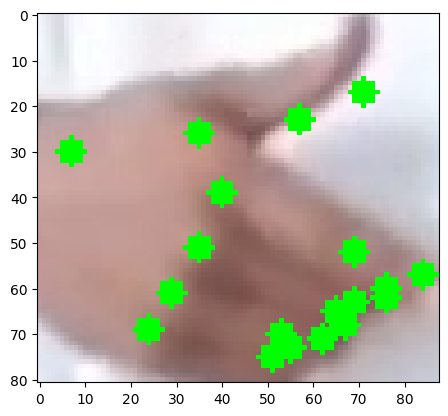

In [116]:
for i in range(0, len(keypoints), 2):
    x = int(keypoints[i] * (x_max-x_min))
    y = int(keypoints[i+1] * (y_max-y_min))
    cv2.circle(image, (x, y), 0, (0, 255, 0), 5)
plt.imshow(image)